In [32]:
from datetime import datetime

# Obtener la fecha actual
fecha_actual = datetime.now()

# Formatear la fecha en YYYY-MM-DD
nombre_fecha = fecha_actual.strftime('%Y-%m-%d')

# Crear el nombre del archivo
nombre_archivo = f'Clase_{nombre_fecha}'

print(nombre_archivo)


Clase_2025-08-13


# 1. Tincho

### Criterio de selección de parámetros:

* **n_samples** = 100: Representa 100 horas de observación, adecuado para el rápido crecimiento de E. coli.
* **base = 1.2**: Refleja un crecimiento exponencial rápido, típico de E. coli en condiciones óptimas.
* **scale =

In [33]:
import numpy as np
from numpy import log
import pandas as pd

# Parámetros para la generación de datos
n_samples = 100  # Número de muestras (horas)
horas = np.arange(1, n_samples + 1)
base = 1.15  # Base de la función exponencial (crecimiento de E. coli)
scale = 10**2.8 # Escala del ruido

# Generar datos exponenciales con ruido
np.random.seed(0)  # Para reproducibilidad
poblacion = base ** horas # Ojo, es un np.array porque horas lo es

# Ajustar la escala del ruido en función del tamaño del índice
noise_scale = scale *(2.5*horas)
noise = np.random.normal(0, noise_scale, size=poblacion.shape)
poblacion_noisy = poblacion + noise

#print(noise)
# Crear el dataframe
df_tincho = pd.DataFrame({'Horas': horas, 'Capital': poblacion_noisy})

# Guardar el dataframe en un archivo CSV
df_tincho.to_csv('tincho.csv', index=False)

df_tincho



,Horas,Capital
0,1,2.783754e+03
1,2,1.263733e+03
2,3,4.633085e+03
3,4,1.414083e+04
4,5,1.473138e+04
...,...,...
95,96,7.784137e+05
96,97,7.737367e+05
97,98,1.164018e+06
98,99,1.040961e+06


<Axes: xlabel='Horas', ylabel='Capital'>

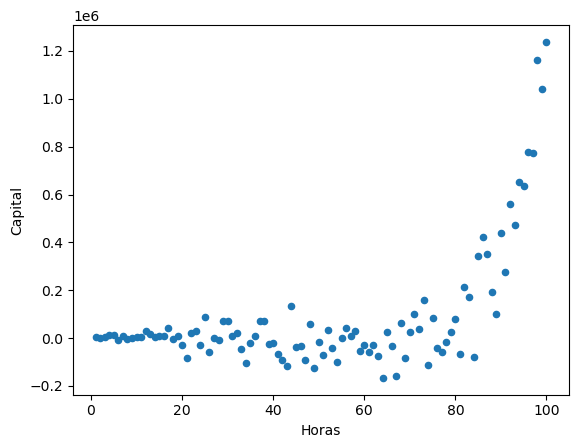

In [34]:
df_tincho.plot.scatter(x='Horas', y='Capital')

# Ahora queremos fittear esto con una curva

In [35]:
#df_tincho['Log Capital'] = np.log(df_tincho['Capital'])


df_tincho['Log Capital'] = df_tincho['Capital'].apply(
    lambda x: log(x) if x > 0 else -log(abs(x))
)

df_tincho

,Horas,Capital,Log Capital
0,1,2.783754e+03,7.931556
1,2,1.263733e+03,7.141825
2,3,4.633085e+03,8.440978
3,4,1.414083e+04,9.556822
4,5,1.473138e+04,9.597735
...,...,...,...
95,96,7.784137e+05,13.565013
96,97,7.737367e+05,13.558987
97,98,1.164018e+06,13.967388
98,99,1.040961e+06,13.855655


<Axes: xlabel='Horas', ylabel='Log Capital'>

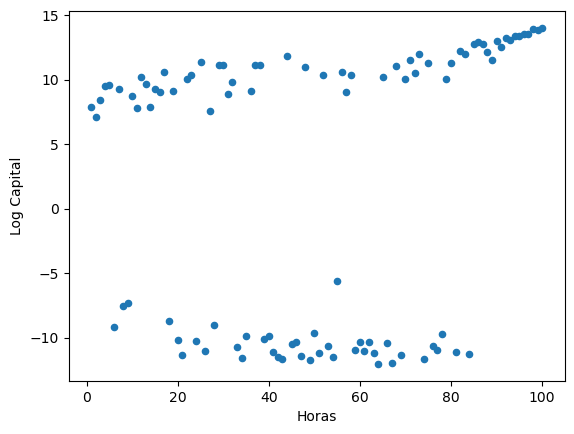

In [36]:
df_tincho.plot.scatter('Horas', 'Log Capital')

## El problema con lo anterior es que la nube no se distribuye en forma lineal al aplicarle $ln$. Tenemos 2 nubes...

### Primera solución: dropear los valores negativos con un filtro y modelar eso



In [37]:
# Creamos un nuevo DataFrame con solo los valores de Capital > 0
df_positivo = df_tincho[df_tincho['Capital'] > 0].copy()

# Aplicamos la transformación logarítmica
df_positivo['Log Capital'] = np.log(df_positivo['Capital'])

# Definimos nuestras variables para el cálculo
# t (Horas) es nuestra variable independiente
# b (Log Capital) es nuestra variable dependiente
t = df_positivo['Horas'].to_numpy()
b = df_positivo['Log Capital'].to_numpy()

# Cantidad de puntos de datos
tamaño_muestra = len(b)
unos = np.ones(tamaño_muestra)

# Creamos la matriz de diseño A
A = np.c_[unos, t]
At = A.T

# Resolviendo las ecuaciones normales (A^T * A) * [C, D] = A^T * b
C, D = np.linalg.solve(At @ A, At @ b)

# --- 3. Interpretación de los resultados ---

# Recordamos que nuestra recta es b_ajustado = C + D*t
# Donde b_ajustado es ln(Capital)
# Y t es Horas

# Por lo tanto, el modelo exponencial resultante, partiendo de Capital = K * exp(r*t), es exp(C)*exp(D*t)


K_estimado = np.exp(C)
r_estimado = D


def recta_cm_log(t_val):
   return C + D * t_val




In [38]:
df_positivo['recta_cm_log'] = C + D*df_positivo['Horas']

df_positivo.head()

,Horas,Capital,Log Capital,recta_cm_log
0,1,2783.754459,7.931556,8.535734
1,2,1263.733148,7.141825,8.581259
2,3,4633.085270,8.440978,8.626785
3,4,14140.829229,9.556822,8.672310
4,5,14731.379234,9.597735,8.717836


<Axes: xlabel='Horas', ylabel='Log Capital'>

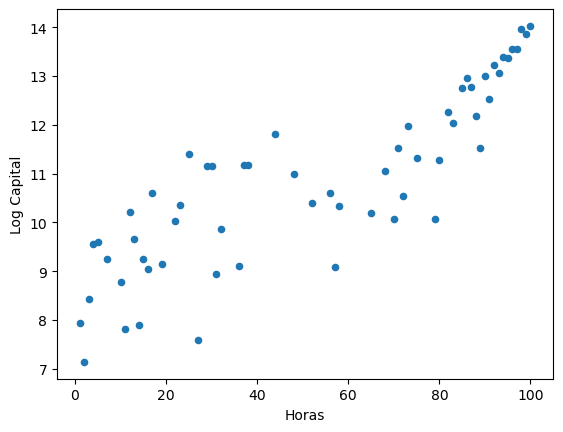

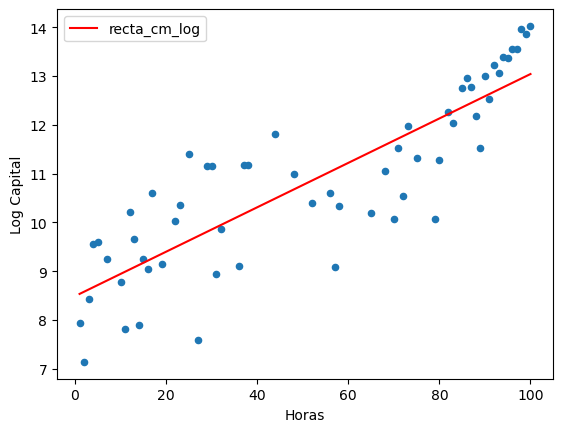

In [39]:
df_positivo.plot.scatter('Horas', 'Log Capital')

ax = df_positivo.plot.scatter('Horas', 'Log Capital')

df_positivo.plot('Horas', 'recta_cm_log',color = 'red', ax = ax)

<Axes: xlabel='Horas', ylabel='Capital'>

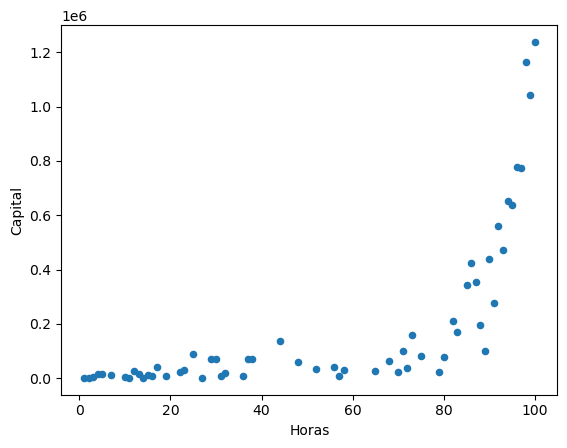

In [40]:
df_positivo.plot.scatter('Horas', 'Capital')



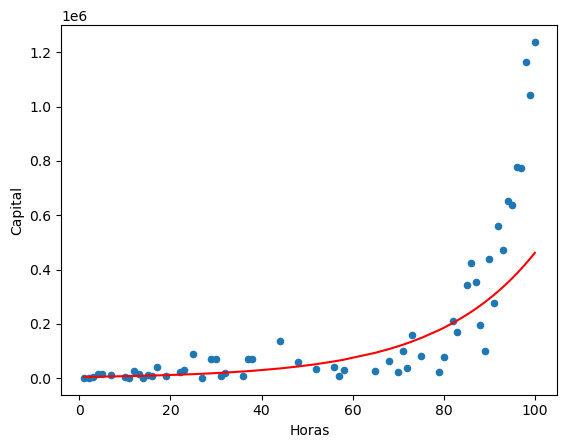

In [41]:
ax = df_positivo.plot.scatter('Horas', 'Capital')

# Creamos la curva exponencial ajustada
curva_exponencial = K_estimado * np.exp(D * df_positivo['Horas'])

# Superponemos la curva sobre el plot original
ax.plot(df_positivo['Horas'], curva_exponencial, color='red', linestyle='-', label='Curva Exponencial Ajustada')
